In [1]:
import matplotlib.pyplot as plt
import numpy as np
import torch
# from jupyterthemes import jtplot
# jtplot.style(theme='gruvboxd', ticks=True, grid=False, figsize=(12, 6), fscale=1.4)
plt.rc('text', usetex=True)
%matplotlib inline
import sys
sys.path.insert(0, "../signal_processing_and_visualization")
from pyrates.utility import Interactive2DParamPlot
from pandas import DataFrame

# Introduction to Dynamical Systems Modeling with PyRates

<br/>
<p style="text-align: center;">presented by Richard Gast </p>

<br/>
Kennedy lab meeting, 09/23/2022

## Overview: Dynamical Systems (DS) Modeling

<br/>

- describe evolution of system over time (continuous or discrete time)

- continuous-time systems are defined via differential equation (DE) systems:
<br/>

<span style="font-size:40px">
$$\dot y = f(y, \theta, t ) = \frac{dy}{dt}$$
</span>

- DE systems define a vector-field over the state space of the system

- we are interested in the solutions to these DE systems
<span style="font-size:40px">
$$y(t) = \int f(y, \theta, t) dt$$
</span>

- ...and how they depend on the system parameters $\theta$

- Numerical methods exist, for example, for:
    - approximating $y(t)$ given a particular choice for $\theta$
    - estimating how $y(t)$ changes for small changes in $\theta$
    - optimizing $\theta$ in order to generate a target solution $y(t)$

## PyRates: Software for DS modeling

<img src="pyrates_bg.png" width="900">

Freely available at [github](https://github.com/pyrates-neuroscience/PyRates), with a detailed documentation and various use examples at [readthedocs](https://pyrates.readthedocs.io/en/latest/).

### DS modeling: The brain as a complex DS

<img src="pyrates_brainscales.png" width="900">

### DS modeling: Neuroscience applications

<br/>

**Can be applied to any scale of brain organization or function:**

- DEs for modeling ion channel dynamics in part of the membrane: Hodgkin-Huxley equations (1952-55)

- DEs for firing of a single neuron: Ermentrout-Kopell equations (1986)

- DEs for firing rate dynamics of a neural population: Montbrio et al. (2015) 

- DEs for dynamics of a cortical column/brain region: Jansen and Rit (1995), Wilson and Cowan (1972)

- DEs for action kinetics and motor program selection: Haken (1976)

- DEs for decision making processes: Busemeyer and Johnson (2004)
- ...

**Neuroscience questions and how to address them via DS modeling:**

- <span style="color:orange">How does an AMPA blocker affect the interaction between cortical layers?</span>
    - Define evolution equations for interacting neuron populations in cortical column
    - Specify which synapses use AMPA
    - Perform parameter sweep or parameter continuation over maximum conductance of AMPA synapses
    - Integrate DEs to evaluate the system dynamics and examine synchronization between neuron populations (coherence, cross-correlation, ...)

- <span style="color:orange">What causes striatal neuron populations to express increased synchronization under dopamine depletion as compared to control conditions?</span>
    - Define evolution equations for interacting neuron populations in striatum
    - Find a data set with recordings from striatal neurons under dopamine depleted and control conditions
    - Optimize model parameters to data of each condition (requires integration of the DEs)
    - Examine differences between the two distinct optimized parameter sets

### DS modeling (example): RNN of rate-coupled leaky-integrator (LI) neurons

Evolution equations for $N$ coupled LI neurons:
<span style="font-size:20pt">
$$ \dot u_i = -\frac{u_i}{\tau} + I_{ext}(t) + k \sum_{j=1}^{N} J_{ij} \tanh (u_j)$$
</span>

**Variables:**
- $u_i$: state variable of neuron $i$
- $\tau$: global rate decay time constant
- $I_{ext}$: Extrinsic input/forcing signal
- $k$: global coupling constant
- $J_{ij}$: Pairwise coupling strengths
- $N$: number of rate neurons

**Question:** How does the dynamic regime of the system depend on the global coupling $k$ and the global time constant $\tau$?

### DS modeling (example): Simulations via PyRates/RectiPy

In [2]:
node = "neuron_model_templates.rate_neurons.leaky_integrator.tanh"
N = 5
J = np.random.randn(N, N)
k = 1.5
tau = 0.5
dt = 1e-3

Text(0.5, 1.0, '$J_{ij}$')

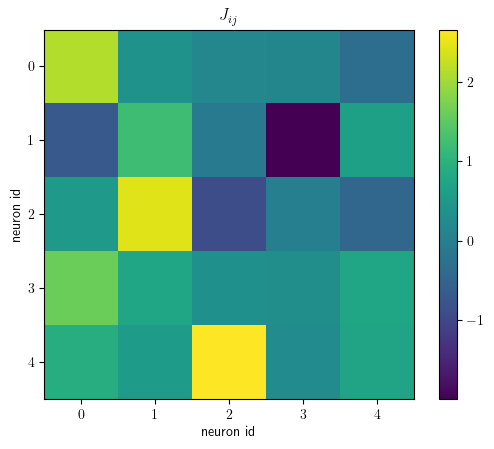

In [3]:
plt.imshow(J)
plt.colorbar()
plt.xlabel("neuron id")
plt.ylabel("neuron id")
plt.title(r"$J_{ij}$")

<span style="font-size:20pt">
$$ \dot u_i = -\frac{u_i}{\tau} + I_{ext}(t) + k \sum_{j=1}^{N} J_{ij} \tanh (u_j)$$
</span>

In [4]:
from rectipy import Network

net0 = Network(dt=dt, device="cpu")

net0.add_diffeq_node(
    label="rate_pop", node=node, weights=J, source_var="tanh_op/r", target_var="li_op/r_in", 
    input_var="li_op/I_ext", output_var="li_op/v", clear=True,
    node_vars={"all/li_op/k": k, "all/li_op/tau": tau}
)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


RateNet()

In [5]:
# define input
steps = 10000
target_neuron = 3
time = np.arange(0, steps)*dt
I_ext = np.zeros((steps, N))
I_ext[:, target_neuron] = np.sin(np.pi*time) * 0.5

# run simulation
obs = net0.run(inputs=I_ext, verbose=False)

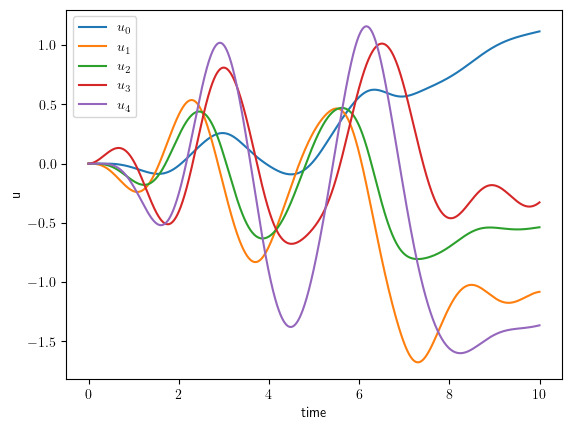

In [6]:
# plotting
ax = obs.plot("out")
ax.set_ylabel("u")
plt.legend([rf"$u_{i}$" for i in range(N)])

## PyRates: A Python tool for DS modeling

<img src="pyrates_structure.png" width="900">

### PyRates: Installation

<br/>

Recommended: Use dedicated Python environment

    
```
conda create -n ds python=3.9
```
    
</span>

Installation via pip:
```
pip install pyrates
```

Dependencies:
- numpy
- networkx
- pandas
- ruamel.yaml
- sympy
- scipy

For full backend support:
- tensorflow
- torch
- matlab
- julia
- gfortran

### PyRates: Model definition



- hierarchical, graph-based
- two frontend interfaces: YAML or pure Python
- detailed introductions to the model definition on [readthedocs](https://pyrates.readthedocs.io/en/latest/) for the [YAML](https://pyrates.readthedocs.io/en/latest/auto_implementations/yaml_definitions.html#sphx-glr-auto-implementations-yaml-definitions-py) and [Python](https://pyrates.readthedocs.io/en/latest/auto_implementations/python_definitions.html#sphx-glr-auto-implementations-python-definitions-py) interface

**Implementation of the rate neuron model via the Python interface**

<span style="font-size:20pt">
$$ \dot u_i = -\frac{u_i}{\tau} + I_{ext}(t) + k \sum_{j=1}^{N} J_{ij} \tanh (u_j)$$
</span>

*Step 1:* Define mathematical operators

In [7]:
from pyrates import OperatorTemplate

# leaky integration operator
equation = "u' = -u/tau + k*r_in + I_ext"
variables = {"u": "output(0.0)", "tau": tau, "k": k, 
             "r_in": "input", "I_ext": "input"}
li_op = OperatorTemplate("li_op", equations=equation, variables=variables)

In [8]:
# hyperbolic tangent transform
equation = "r = tanh(u)"
variables = {"r": "output(0.1)", "u": "input"}
tanh_op = OperatorTemplate("tanh_op", equations=equation, variables=variables)

*Step 2:* Connect operators to define nodes 

In [9]:
from pyrates import NodeTemplate
node = NodeTemplate("neuron", operators=[li_op, tanh_op])

*Step 3:* Connect nodes to define a circuit

In [10]:
from pyrates import CircuitTemplate

# initialize network with unconnected nodes
nodes = [f"n_{i}" for i in range(N)]
net = CircuitTemplate("net", nodes={n: node for n in nodes})

In [11]:
# add edges between nodes
net.add_edges_from_matrix(source_var="tanh_op/r", target_var="li_op/r_in", 
                          source_nodes=nodes, weight=J)

In [12]:
net.edges

[('n_0/tanh_op/r', 'n_0/li_op/r_in', None, {'weight': 2.117593118203504}),
 ('n_0/tanh_op/r', 'n_1/li_op/r_in', None, {'weight': -0.6888601577724345}),
 ('n_0/tanh_op/r', 'n_2/li_op/r_in', None, {'weight': 0.5153753015331314}),
 ('n_0/tanh_op/r', 'n_3/li_op/r_in', None, {'weight': 1.6157548386308311}),
 ('n_0/tanh_op/r', 'n_4/li_op/r_in', None, {'weight': 0.9015680130598264}),
 ('n_1/tanh_op/r', 'n_0/li_op/r_in', None, {'weight': 0.3931599330334068}),
 ('n_1/tanh_op/r', 'n_1/li_op/r_in', None, {'weight': 1.215529816174013}),
 ('n_1/tanh_op/r', 'n_2/li_op/r_in', None, {'weight': 2.4264808336648405}),
 ('n_1/tanh_op/r', 'n_3/li_op/r_in', None, {'weight': 0.7593295779967787}),
 ('n_1/tanh_op/r', 'n_4/li_op/r_in', None, {'weight': 0.5863028827428648}),
 ('n_2/tanh_op/r', 'n_0/li_op/r_in', None, {'weight': 0.1598667351764953}),
 ('n_2/tanh_op/r', 'n_1/li_op/r_in', None, {'weight': -0.09286744164483693}),
 ('n_2/tanh_op/r', 'n_2/li_op/r_in', None, {'weight': -0.892362487362823}),
 ('n_2/tanh

### PyRates: Applications


- translate model equations into compute graph

- uses code-generation to generate functions that allow to evaluate the vector-field of a given model, i.e. $\dot y = f(y,\theta,t)$.

- vector-field evaluation functions generated by *PyRates* provide interface to various dynamical systems optimization/analysis tools

**Code-generation example:** `NumPy`, `Fortran`

In [13]:
_ = net.get_run_func("vecfield", file_name="numpy_func", 
                     step_size=dt, backend="numpy", 
                     in_place=False, vectorize=False, clear=False)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


In [14]:
f = open("numpy_func.py", "r")
print("")
print(f.read())
f.close()

from pyrates import clear
clear(net)


from numpy import pi, sqrt
from numpy import tanh


def vecfield(t,y,dy,tau,k,I_ext,tau_v1,k_v1,I_ext_v1,tau_v2,k_v2,I_ext_v2,tau_v3,k_v3,I_ext_v3,tau_v4,k_v4,I_ext_v4,weight_in0_v1,weight_in0_v2,weight_in1_v2,weight_in0_v3,weight_in1_v3,weight_in2_v3,weight_in0_v4,weight_in1_v4,weight_in2_v4,weight_in3_v4,weight_in0,weight_in1,weight_in2,weight_in3,weight_in4,weight_in1_v1,weight_in2_v1,weight_in3_v1,weight_in4_v1,weight_in2_v2,weight_in3_v2,weight_in4_v2,weight_in3_v3,weight_in4_v3,weight_in4_v4):


	u = y[0]
	u_v1 = y[1]
	u_v2 = y[2]
	u_v3 = y[3]
	u_v4 = y[4]
	r_in0 = tanh(u)
	r_in_in0_v1 = r_in0*weight_in0_v1
	r_in1 = tanh(u_v1)
	r_in_in0_v2 = r_in0*weight_in0_v2
	r_in_in1_v2 = r_in1*weight_in1_v2
	r_in2 = tanh(u_v2)
	r_in_in0_v3 = r_in0*weight_in0_v3
	r_in_in1_v3 = r_in1*weight_in1_v3
	r_in_in2_v3 = r_in2*weight_in2_v3
	r_in3 = tanh(u_v3)
	r_in_in0_v4 = r_in0*weight_in0_v4
	r_in_in1_v4 = r_in1*weight_in1_v4
	r_in_in2_v4 = r_in2*weight_in2_v4
	r_in_in3_v4 = r_in3*weight_in3_v4
	r_

In [15]:
_ = net.get_run_func("vecfield", file_name="tf_func", 
                     step_size=dt, backend="tensorflow", 
                     in_place=False, vectorize=True, clear=False)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...


2024-06-24 15:54:34.112184: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-24 15:54:34.189451: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-06-24 15:54:34.540081: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2024-06-24 15:54:34.540110: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not l

		...finished.
	Model compilation was finished.


2024-06-24 15:54:36.466360: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:981] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2024-06-24 15:54:36.466624: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcufft.so.10'; dlerror: libcufft.so.10: cannot open shared object file: No such file or directory
2024-06-24 15:54:36.466668: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcurand.so.10'; dlerror: libcurand.so.10: cannot open shared object file: No such file or directory
2024-06-24 15:54:36.466701: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcusolver.so.11'; dlerror: libcusolver.so.11: cannot open shared object file: No such file or directory
2024-06-24 15:54:36.466732: W tensorflow/compile

In [16]:
f = open("tf_func.py", "r")
print("")
print(f.read())
f.close()

clear(net)


from numpy import pi, sqrt
from tensorflow.linalg import matvec
from tensorflow import tanh


def vecfield(t,y,dy,tau,k,I_ext,weight):


	u = y[0:5]
	r = tanh(u)
	r_in = matvec(weight, r)
	
	dy.scatter_nd_update([[0], [1], [2], [3], [4]], I_ext + k*r_in - u/tau)

	return dy


## Example 1: Parameter sweep

<br/>

<span style="font-size:20pt">
$$ \dot u_i = -\frac{u_i}{\tau} + I_{ext}(t) + k \sum_{j=1}^{N} J_{ij} \tanh (u_j)$$
</span>

We perform a parameter sweep over global coupling constant $k$ and global decay time constant $\tau$

In [17]:
from pyrates import grid_search

# define sweep
ks = np.asarray([0.25, 0.5, 1.0, 2.0, 4.0])
taus = np.asarray([0.25, 0.5, 1.0, 2.0, 4.0])

# pointers to model parameters
param_map = {"k": {"vars": ["li_op/k"], "nodes": nodes}, 
             "tau": {"vars": ["li_op/tau"], "nodes": nodes}}

In [18]:
# integration time and step-size
T = 10.0
dt = 1e-3

# perform sweep
res, mapping = grid_search(
    net, param_grid={"k": ks, "tau": taus}, param_map=param_map, permute_grid=True,
    simulation_time=T, step_size=dt, solver="scipy", method="RK45",
    outputs={"u": "all/li_op/u"}, inputs={f"n_{target_neuron}/li_op/I_ext": I_ext[:, target_neuron]}
)

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Simulation Progress
-------------------
	 (1) Generating the network run function...
	 (2) Processing output variables...
		...finished.
	 (3) Running the simulation...
		...finished after 0.023090844002581434s.


### Example 1: Results

In [19]:
C = np.zeros((len(ks), len(taus)))
for col, tau in enumerate(taus):
    for row, k in enumerate(ks):
        idx = (mapping["k"] - k < 0.1) & (mapping["tau"] - tau < 0.1)
        data = res["u"][mapping.index[idx]]
        v = np.std(data, axis=0)
        C[row, col] = np.mean(v[:])

In [20]:
%matplotlib notebook
obj = Interactive2DParamPlot(C, res["u"], taus, ks, "tau", "k", mapping, cmap_lines="viridis")

<IPython.core.display.Javascript object>

/home/rgf3807/PycharmProjects/PyRates/pyrates/utility.py:355: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.ax[0].set_xticklabels([""] + list(np.round(x_values, decimals=2)))
/home/rgf3807/PycharmProjects/PyRates/pyrates/utility.py:356: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  self.ax[0].set_yticklabels([""] + list(np.round(y_values, decimals=2)))


`grid_search` calls return two `pandas.DataFrame` objects: 
1. the system variables over time (`res`)
2. the parameter grid (`mapping`)

In [21]:
res["u"]["net_0"]

,n_0,n_1,n_2,n_3,n_4
,li_op/u,li_op/u,li_op/u,li_op/u,li_op/u
0.000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
0.001,9.098092e-12,-1.304552e-10,1.215919e-12,7.842926e-07,1.648519e-11
0.002,7.264204e-11,-1.041862e-09,9.588934e-12,3.133068e-06,1.316264e-10
0.003,2.446099e-10,-3.509486e-09,3.174013e-11,7.040177e-06,4.432547e-10
0.004,5.784754e-10,-8.302444e-09,7.372039e-11,1.249948e-05,1.048311e-09
...,...,...,...,...,...
9.995,-5.291961e-04,1.004621e-02,9.725502e-04,-6.337462e-02,-9.516132e-04
9.996,-5.284606e-04,1.004054e-02,9.742723e-04,-6.313356e-02,-9.499676e-04
9.997,-5.277199e-04,1.003478e-02,9.759848e-04,-6.289188e-02,-9.483126e-04


In [22]:
mapping

,k,tau
net_0,0.25,0.25
net_1,0.50,0.25
net_2,1.00,0.25
net_3,2.00,0.25
net_4,4.00,0.25
net_5,0.25,0.50
net_6,0.50,0.50
net_7,1.00,0.50
net_8,2.00,0.50
net_9,4.00,0.50


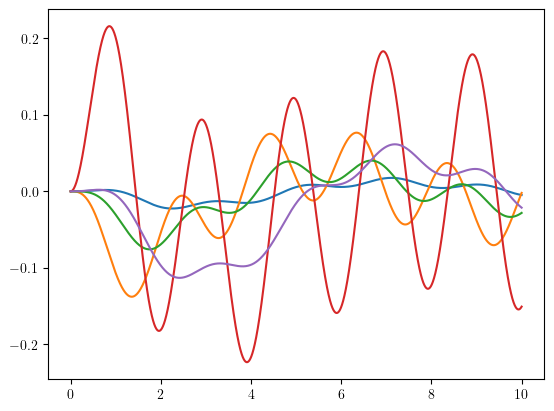

In [23]:
%matplotlib inline
_ = plt.plot(res["u"]["net_11"])

## Example 2: Parameter optimization

We will perform automated optimization of $k$ and $\tau$ via *RectiPy*. 

In [24]:
# target parameters
k_t = np.random.uniform(0.25, 4.0)
tau_t = np.random.uniform(0.25, 4.0)

# starting parameters
k_0 = np.random.uniform(0.25, 4.0)
tau_0 = np.random.uniform(0.25, 4.0)

print("Target parameters: " + r"$k_t$ = " + f"{k_t}" + r", $\tau_t$ = " + f"{tau_t}.")
print("Starting parameters: " + r"$k_0$ = " + f"{k_0}" + r", $\tau_0$ = " + f"{tau_0}.")

Target parameters: $k_t$ = 3.8819334579585485, $\tau_t$ = 0.35223178215720025.
Starting parameters: $k_0$ = 1.4961153749847973, $\tau_0$ = 2.0238041954296273.


In [25]:
# target model initialization
tnet = Network(dt, device="cpu")
tnet.add_diffeq_node("n1", node=node, weights=J, source_var="tanh_op/r", target_var="li_op/r_in", 
                     input_var="li_op/I_ext", output_var="li_op/u", clear=True,
                     node_vars={"all/li_op/k": k_t, "all/li_op/tau": tau_t})

# test model initialization
lnet = Network(dt, device="cpu")
lnet.add_diffeq_node("n1", node=node, weights=J, source_var="tanh_op/r", target_var="li_op/r_in", 
                     input_var="li_op/I_ext", output_var="li_op/u", clear=True,
                     node_vars={"all/li_op/k": k_0, "all/li_op/tau": tau_0},
                     train_params=["li_op/k", "li_op/tau"])

Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.
Compilation Progress
--------------------
	(1) Translating the circuit template into a networkx graph representation...
		...finished.
	(2) Preprocessing edge transmission operations...
		...finished.
	(3) Parsing the model equations into a compute graph...
		...finished.
	Model compilation was finished.


RateNet()

In [26]:
tnet.compile()
lnet.compile()
print(list(tnet.parameters()))
print(list(lnet.parameters()))

[]
[tensor([1.4961], dtype=torch.float64, requires_grad=True), tensor([2.0238], dtype=torch.float64, requires_grad=True)]


In [27]:
# define optimization algorithm and loss function
opt = torch.optim.Rprop(lnet.parameters(), lr=0.01, etas=(0.5, 1.1), step_sizes=(1e-5, 1e-1))
loss = torch.nn.MSELoss()

# set some meta parameters
step, update_steps, plot_steps = 0, 1000, 100

In [28]:
%matplotlib notebook

# prepare figure for online tracking of optimization progress
fig, ax = plt.subplots(ncols=2)
ax[0].set_xlabel("training steps")
ax[0].set_ylabel("MSE")
ax[1].set_xlabel("training steps")
ax[1].set_ylabel(r"$u$")

<IPython.core.display.Javascript object>

Text(0, 0.5, '$u$')

In [32]:
# perform optimization
mse_col, target_col, prediction_col = [], [], []
error, tol = 1.0, 1e-4
l = torch.zeros((1,))
while error > tol:
    
    # calculate forwards
    I_ext = np.sin(np.pi*step*dt)*0.5
    target = tnet.forward(I_ext)
    prediction = lnet.forward(I_ext)
    step += 1
    
    # calculate loss and make optimization step
    l += loss(target, prediction)
    if step % update_steps == 0:
        l.backward()
        opt.step()
        opt.zero_grad()
        l = torch.zeros((1,))
        lnet.detach()
    error = 0.9*error + 0.1*l.item()
    
    # plotting
    mse_col.append(error)
    target_col.append(target.detach().numpy()[target_neuron])
    prediction_col.append(prediction.detach().numpy()[target_neuron])
    if step % plot_steps == 0:
        ax[0].plot(mse_col, "red")
        ax[1].plot(target_col, "blue")
        ax[1].plot(prediction_col, "orange")
        plt.legend([rf"$u_{target_neuron}$ (target)", rf"$u_{target_neuron}$ (learner)"])
        fig.canvas.draw()
        fig.canvas.flush_events()

<IPython.core.display.Javascript object>

RuntimeError: one of the variables needed for gradient computation has been modified by an inplace operation: [torch.DoubleTensor [1]] is at version 1; expected version 0 instead. Hint: enable anomaly detection to find the operation that failed to compute its gradient, with torch.autograd.set_detect_anomaly(True).

In [31]:
# collect optimized parameters
params = list(lnet.parameters())
k = params[0].clone().detach().numpy()
tau = params[1].clone().detach().numpy()

# display optimization result
print("Target parameters: " + r"$k_t$ = " + f"{k_t}" + r", $\tau_t$ = " + f"{tau_t}.")
print("Starting parameters: " + r"$k_0$ = " + f"{k_0}" + r", $\tau_0$ = " + f"{tau_0}.")
print("Optimized parameters: " + r"$k_*$ = " + f"{k[0]}" + r", $\tau_*$ = " + f"{tau[0]}.")

Target parameters: $k_t$ = 3.8819334579585485, $\tau_t$ = 0.35223178215720025.
Starting parameters: $k_0$ = 1.4961153749847973, $\tau_0$ = 2.0238041954296273.
Optimized parameters: $k_*$ = 1.4961153749847973, $\tau_*$ = 2.0238041954296273.


## Summary

- [PyRates](https://github.com/pyrates-neuroscience/PyRates) is a model definition and code generation tool for differential equation-based dynamical systems

- makes model definitions re-usable and sharable

- generates vector-field evaluation functions for tons of backends

- allows to perform pretty much any numerical dynamical systems analysis method out there, using the best tools availabe

- [RectiPy](https://github.com/pyrates-neuroscience/RectiPy) is a RNN simulation and optimization tool built on top of *PyRates* and *PyTorch* that allows to fit RNNs (rate-units or spiking units) to data 